<a href="https://colab.research.google.com/github/Sayan3sarkar/Handwritten_Digit_Recognition_using_Tensorflow/blob/master/Handwritten_Digit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Handwritten Digit  Recognition from [MNIST](http://yann.lecun.com/exdb/mnist/?source=post_page---------------------------) Dataset with a CNN using [Tensorflow](https://www.tensorflow.org/)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Loading Dataset

In [3]:
data = input_data.read_data_sets('data/MNIST/', one_hot = True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


## EDA on Dataset

In [4]:
# Shape of Training set

print("Training Set(images) shape: {shape}".format(shape= data.train.images.shape))
print("Training Set(labels) shape: {shape}".format(shape= data.train.labels.shape))

# Shape of Test set

print("Test Set(images) shape: {shape}".format(shape= data.test.images.shape))
print("Test Set(labels) shape: {shape}".format(shape= data.test.labels.shape))

Training Set(images) shape: (55000, 784)
Training Set(labels) shape: (55000, 10)
Test Set(images) shape: (10000, 784)
Test Set(labels) shape: (10000, 10)


## Let's take a look at the 6th image(randomly chosen) of our training and test set

Training set image:



Text(0.5, 1.0, 'Label:8')

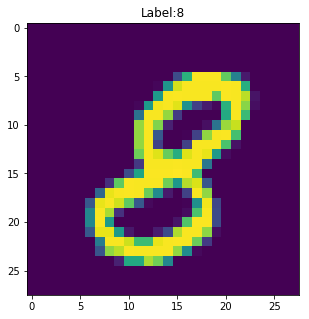

In [5]:
print("Training set image:\n")
plt.figure(figsize= [5,5])

curr_img = np.reshape(data.train.images[5],(28,28))
curr_lbl = np.argmax(data.train.labels[5,:])
plt.imshow(curr_img)
plt.title("Label:{}".format(str(curr_lbl)))

Test set image:



Text(0.5, 1.0, 'Label:1')

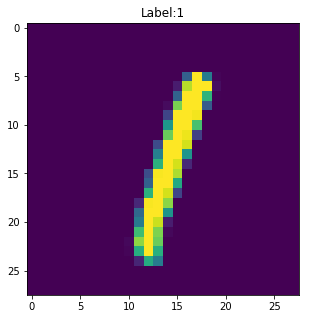

In [6]:
print("Test set image:\n")
plt.figure(figsize= [5,5])

curr_img = np.reshape(data.test.images[5],(28,28))
curr_lbl = np.argmax(data.test.labels[5,:])
plt.imshow(curr_img)
plt.title("Label:{}".format(str(curr_lbl)))

## Data Preprocessing

Images are already scaled between 0 and 1.We reshape the images to **28x28x1** to feed into the network.

In [7]:
train_X =  data.train.images.reshape(-1,28,28,1)
test_X = data.test.images.reshape(-1,28,28,1)

train_X.shape,test_X.shape

((55000, 28, 28, 1), (10000, 28, 28, 1))

In [8]:
train_y = data.train.labels
test_y = data.test.labels

train_y.shape, test_y.shape

((55000, 10), (10000, 10))

## Our CNN architecture

1. First layer has **32-3x3** filters.

2. Second layer has **64-3x3** filters.

3. Third layer has **128-3x3** filters. 

  Also, there are total of 3 **max_pooling** layers of dimensions **2x2**. Each placed in between each of the 3 previously defined **Convolution Layers**.

4. **Training Iterations = 200** , **Learning Rate = 0.001**, **Batch Size = 128**

5.  **Input to network = 28**, **Total classes = 10**

In [0]:
training_iters = 200
learning_rate = 0.001
batch_size = 128
n_inputs = 28
n_classes = 10

## Defining Input and output placeholders. 

Note: Row of placeholders are set to **None** as **batch_size = 128** willl be the row for the network which is provided at run time

In [0]:
x = tf.placeholder("float", [None, 28, 28, 1])
y = tf.placeholder("float", [None, n_classes])

## Defining method conv2d() to perform convolution

In [0]:
def conv2d(x, W, b, strides=1):
  x = tf.nn.conv2d(x, W, strides= [1, strides, strides, 1], padding = 'SAME') #padding = 'SAME' ensures the boundary pixels of the image are not left out while performing convolution
  x = tf.nn.bias_add(x, b)
  return tf.nn.relu(x)

## Defining method maxpool2d() to perform maxpooling

In [0]:
def maxpool2d(x, k = 2):
  return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'SAME')

### We create dictionary for weights and biases to feed into the CNN. But let's understand the logic behind assigning these weights and biases:


*   As we can recall, we want our **1st convolution layer** to have **32-3x3** filters. So, the 1st key (**wc1**) in the weight dictionary has an argument shape that takes a tuple with 4 values: the **1st and 2nd are the filter size**, while the **3rd is the number of channels in the input image** and the **last represents the number of convolution filters we want in the first convolution layer.** The first key in biases dictionary,**bc1**, will have **32** bias parameters.

*  Similarly for the second and third convolution layer having **64 an 128** filters,respectively. The second and third keys of bias dictionary will have 64 and 128 bias parameters,respectively

*   Now, it's important to understand the fourth key (**wd1**). After applying 3 convolution and max-pooling operations, we are downsampling the input image from **28 x 28 x 1** to **4 x 4 x 1** and now we need to flatten this downsampled output to feed this as input to the fully connected layer. That's why we do the multiplication operation **4x4x128**, which is the output of the previous layer or number of channels that are outputted by the convolution layer 3. The second element of the tuple that we pass to shape has number of nodes that we want in the fully connected layer,i.e **128**. Similarly, in biases dictionary, the fourth key **bd1** has **128** parameters

In [0]:
weights = {
    'wc1' : tf.get_variable('W0', shape = (3, 3, 1, 32), initializer = tf.contrib.layers.xavier_initializer()),
    'wc2' : tf.get_variable('W1', shape = (3, 3, 32, 64), initializer = tf.contrib.layers.xavier_initializer()),
    'wc3' : tf.get_variable('W2', shape = (3, 3, 64, 128), initializer = tf.contrib.layers.xavier_initializer()),
    'wd1' : tf.get_variable('W3', shape = (4*4*128, 128), initializer = tf.contrib.layers.xavier_initializer()),
    'out' : tf.get_variable('W4', shape = (128, n_classes), initializer = tf.contrib.layers.xavier_initializer())
}

biases = {
    'bc1' : tf.get_variable('B0', shape = (32), initializer = tf.contrib.layers.xavier_initializer()),
    'bc2' : tf.get_variable('B1', shape = (64), initializer = tf.contrib.layers.xavier_initializer()),
    'bc3' : tf.get_variable('B2', shape = (128), initializer = tf.contrib.layers.xavier_initializer()),
    'bd1' : tf.get_variable('B3', shape = (128), initializer = tf.contrib.layers.xavier_initializer()),
    'out' : tf.get_variable('B4', shape = (10), initializer = tf.contrib.layers.xavier_initializer())
}

## Defining Network Architecture

In [0]:
def conv_net(x, weights, biases):
  
  conv1 = conv2d(x, weights['wc1'], biases['bc1'])
  conv1 = maxpool2d(conv1, k=2)
  
  conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
  conv2 = maxpool2d(conv2, k=2)
  
  conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
  conv3 = maxpool2d(conv3, k=2)
  
  fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
  fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
  fc1 = tf.nn.relu(fc1)
  
  out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
  
  return out

## Calculating Loss function and Optimizer Nodes

In [0]:
pred = conv_net(x, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred, labels = y))## Softmax used since multiclass classification

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

## Evaluating Model nodes

In [0]:
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

accuracy =  tf.reduce_mean(tf.cast(correct_pred, tf.float32))##tf.cast is type casting the correct_pred value to float 32

## Initialize all variables

In [0]:
init = tf.global_variables_initializer()

## Training and Testing the Model

Here, for each epoch, we test accuracy on all 10000 test images.

In [18]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(training_iters):
        for batch in range(len(train_X)//batch_size):
            batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
            batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]    
            
            opt = sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y})
        print("Iter " + str(i) + ", Loss= " +"{:.6f}".format(loss) + ", Training Accuracy= " +"{:.5f}".format(acc))
        print("Optimization Finished!")
        
        # Calculate accuracy for all 10000 mnist test images
        test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()

Iter 0, Loss= 0.009618, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.97730
Iter 1, Loss= 0.007296, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98550
Iter 2, Loss= 0.006015, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98730
Iter 3, Loss= 0.003455, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98890
Iter 4, Loss= 0.008963, Training Accuracy= 0.99219
Optimization Finished!
Testing Accuracy: 0.98490
Iter 5, Loss= 0.001822, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98910
Iter 6, Loss= 0.001264, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98720
Iter 7, Loss= 0.000068, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98700
Iter 8, Loss= 0.001279, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98430
Iter 9, Loss= 0.000302, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98310


In [19]:
np.mean(train_accuracy), np.mean(test_accuracy)

(0.99996096, 0.9924556)

## It can be seen that we obtain a  test set accuracy of 99.24%

### But we can see that our model is overfitting as it's giving 100% accuracy on almost every training iteration. So we apply a dropout layer between each convolution and maxpool layers where 70% of the features are active

In [23]:
keep_prob = tf.placeholder(tf.float32)


def conv_net_new(x, weights, biases, keep_prob):
  
  conv1 = conv2d(x, weights['wc1'], biases['bc1'])
  conv1 = tf.nn.dropout(conv1, keep_prob)
  conv1 = maxpool2d(conv1, k=2)
  
  conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
  conv2 = tf.nn.dropout(conv2, keep_prob)
  conv2 = maxpool2d(conv2, k=2)
  
  conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
  conv3 = tf.nn.dropout(conv3, keep_prob)
  conv3 = maxpool2d(conv3, k=2)
  
  fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
  fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
  fc1 = tf.nn.relu(fc1)
  
  out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
  
  return out



pred = conv_net_new(x, weights, biases, 0.7)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred, labels = y))## Softmax used since multiclass classification

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

accuracy =  tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()



with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(training_iters):
        for batch in range(len(train_X)//batch_size):
            batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
            batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]    
            
            opt = sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y})
        print("Iter " + str(i) + ", Loss= " +"{:.6f}".format(loss) + ", Training Accuracy= " +"{:.5f}".format(acc))
        print("Optimization Finished!")
        
        # Calculate accuracy for all 10000 mnist test images
        test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()

Iter 0, Loss= 0.015661, Training Accuracy= 0.99219
Optimization Finished!
Testing Accuracy: 0.97400
Iter 1, Loss= 0.009594, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98170
Iter 2, Loss= 0.002605, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98540
Iter 3, Loss= 0.002829, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98710
Iter 4, Loss= 0.001300, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98780
Iter 5, Loss= 0.017336, Training Accuracy= 0.98438
Optimization Finished!
Testing Accuracy: 0.98870
Iter 6, Loss= 0.004825, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98810
Iter 7, Loss= 0.002907, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98890
Iter 8, Loss= 0.003159, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98870
Iter 9, Loss= 0.000748, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98880


In [24]:
np.mean(train_accuracy), np.mean(test_accuracy)

(0.99953127, 0.99067)

## We can see that by applying dropout, we achieve a training set accuracy of 99.95% which is a little bit better than 99.996% as obtained earlier,and test set accuracy of 99.06% which is very good.

## We now plot the accuracy and loss plots between training and test set

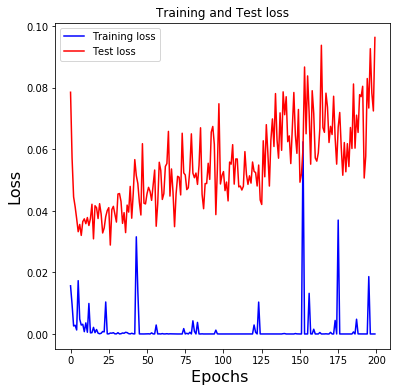

In [25]:
labels = ['Training loss', 'Test loss']
plt.figure(figsize = (6,6))
plt.plot(range(len(train_loss)), train_loss, 'b', label=labels[0])
plt.plot(range(len(train_loss)), test_loss, 'r', label=labels[1])
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend(labels)
plt.show()

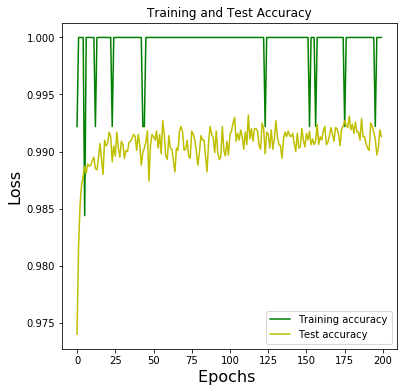

In [26]:
labels = ['Training accuracy', 'Test accuracy']
plt.figure(figsize = (6,6))
plt.plot(range(len(train_accuracy)), train_accuracy, 'g', label=labels[0])
plt.plot(range(len(train_accuracy)), test_accuracy, 'y', label=labels[1])
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend(labels)
plt.show()